## Training Model in Python and Converting to Javascript Prior Deployment

>Author: SarbZone
>>Contact: https://www.sarbzone.com

#### Importing JavaScript version USE (Universal Sentence encoder) 's Embeddings

To deploy model in JavaScript we have to have reliable Embeddings which can help perform model better, So USE is the best to start with,
python version of USE is very large and not able to convert in JavaScript. So, I am using the JavaScript Version of USE to create Embeddings prior Training.


In [1]:
#Defining the Embeddings Folder Address
EMB_DIRECTORY = 'TrainDataGenerator/data-generator-app/EMBEDDING_OUTPUT/'

In [2]:
#Printing All Embedding FileNames
import os
files = os.listdir(EMB_DIRECTORY)
files

['sarb.json', 'output.json', 'unseen-data.json', 'my-portfolio.json']

In [3]:
#Reading the data into Pandas
import pandas as pd

data = pd.read_json(EMB_DIRECTORY+"my-portfolio.json")

data.head()

,Text,Label,Embedding
0,where studdied,education,"[0.054680559784173, -0.008714344352483, -0.011..."
1,you want to specialize in what ?,future,"[0.005911364685744, -0.06791594624519301, -0.0..."
2,certifications,certifications,"[-0.05691860243678001, -0.05575320124626101, -..."
3,how can I contact ?,contact,"[0.015425065532326001, -0.056882746517658005, ..."
4,past job,experience,"[-0.053480073809623004, -0.05391913279891, 0.0..."


#### PreProcessing the data

In [4]:
#Randomizing the Data

data = data.sample(frac=1, random_state=42)

data.head()

,Text,Label,Embedding
9,what are your professional goals ?,future,"[-0.056549005210399, -0.058769285678863005, -0..."
84,your email ?,contact,"[-0.039020631462335004, -0.053663693368434004,..."
117,your tech stack,skills,"[0.022529719397425003, -0.053279757499694005, ..."
144,where is your daughter?,unknown,"[0.038007978349924004, -0.012936396524310001, ..."
220,which one of them is a real world project bein...,projects,"[-0.04945408180356001, -0.06803922355175, 0.05..."


In [5]:
#Creating Features and Targets

X = data['Embedding']
y = data['Label']

X.shape, y.shape

((223,), (223,))

In [6]:
#importing Required Libraries and setting the Random_Seed
import tensorflow as tf 
import tensorflowjs as tfjs
import numpy as np
import keras
from IPython.display import Image, display

def show_image_from_path(image_path):
    display(Image(filename=image_path))

tf.random.set_seed(42)


In [7]:
#Counting the number of classes and doing ONE_HOT Encoding
num_classes = len(np.unique(y))
print(f"Total Classes: {num_classes}")


Total Classes: 19


In [8]:
# Map each class to an integer index
class_to_index = {label: idx for idx, label in enumerate(np.unique(y))}

# Convert labels to integers
labels_int = np.array([class_to_index[label] for label in y])
index_to_class_array = [label for label, index in sorted(class_to_index.items(), key=lambda x: x[1])]
# Perform one-hot encoding using TensorFlow
one_hot_labels = tf.one_hot(labels_int, depth=num_classes)

print("Number of classes:", num_classes)
print("Class to index mapping:", class_to_index)
print("Labels as integers:", labels_int[:2])
print("One-hot encoded labels:")
print(one_hot_labels.numpy()[:2])

Number of classes: 19
Class to index mapping: {'age': 0, 'birthday': 1, 'certifications': 2, 'contact': 3, 'currentjob': 4, 'education': 5, 'experience': 6, 'future': 7, 'greet': 8, 'hobbies': 9, 'how': 10, 'intro': 11, 'motivation': 12, 'name': 13, 'okay': 14, 'projects': 15, 'skills': 16, 'thanks': 17, 'unknown': 18}
Labels as integers: [7 3]
One-hot encoded labels:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
#Converting  data to Tensors

X = tf.constant([X], dtype=tf.float32)
X = tf.squeeze(X)
y = tf.constant(one_hot_labels, dtype=tf.float32)

X.shape, y.shape

(TensorShape([223, 512]), TensorShape([223, 19]))

#### Data Splits
> Due to less data splitting 5% for Test

In [10]:
split = int(len(X)*0.95)
X_train,y_train,X_test,y_test = X[:split],one_hot_labels[:split], X[split:],one_hot_labels[split:]

lengths = {
    "X_train": len(X_train),
    "y_train": len(y_train),
    "X_test": len(X_test),
    "y_test": len(y_test)
}

print("Lengths:\n")
for key, value in lengths.items():
    print(f"{key}: {value}")


Lengths:

X_train: 211
y_train: 211
X_test: 12
y_test: 12


## Creating The Model 🤖

In [11]:
from keras.layers import Dense, LSTM, Input, Bidirectional,Reshape


inputs = Input(shape=(512), dtype=tf.float32)
reshape_layer = Reshape((1, 512))(inputs)
x = Bidirectional(LSTM(128, activation='tanh', return_sequences=True))(reshape_layer)
x = LSTM(256,activation='tanh')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs,outputs, name="text_classification_model_by_sarbzone")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adam(), metrics=['accuracy'])

model.summary()

Model: "text_classification_model_by_sarbzone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 512)            0         
                                                                 
 bidirectional (Bidirection  (None, 1, 256)            656384    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 19)                1235      
                             

In [12]:
## Training the model
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=1000, callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/1000
7/7 [==============================] - 3s 149ms/step - loss: 2.9350 - accuracy: 0.1659 - val_loss: 2.9376 - val_accuracy: 0.0833
Epoch 2/1000
7/7 [==============================] - 0s 24ms/step - loss: 2.8840 - accuracy: 0.2654 - val_loss: 2.9310 - val_accuracy: 0.0833
Epoch 3/1000
7/7 [==============================] - 0s 23ms/step - loss: 2.7583 - accuracy: 0.2654 - val_loss: 2.9678 - val_accuracy: 0.0833
Epoch 4/1000
7/7 [==============================] - 0s 23ms/step - loss: 2.5564 - accuracy: 0.2654 - val_loss: 3.2195 - val_accuracy: 0.0833
Epoch 5/1000
7/7 [==============================] - 0s 22ms/step - loss: 2.4397 - accuracy: 0.2654 - val_loss: 3.0093 - val_accuracy: 0.0833
Epoch 6/1000
7/7 [==============================] - 0s 23ms/step - loss: 2.3182 - accuracy: 0.3223 - val_loss: 2.8577 - val_accuracy: 0.1667
Epoch 7/1000
7/7 [==============================] - 0s 23ms/step - loss: 2.1635 - accuracy: 0.3555 - val_loss: 2.7555 - val_accuracy: 0.1667
Epoch 8/1000

In [13]:
#Evaluating the model on 5% of test
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 37ms/step - loss: 0.4992 - accuracy: 0.7500


[0.49921104311943054, 0.75]

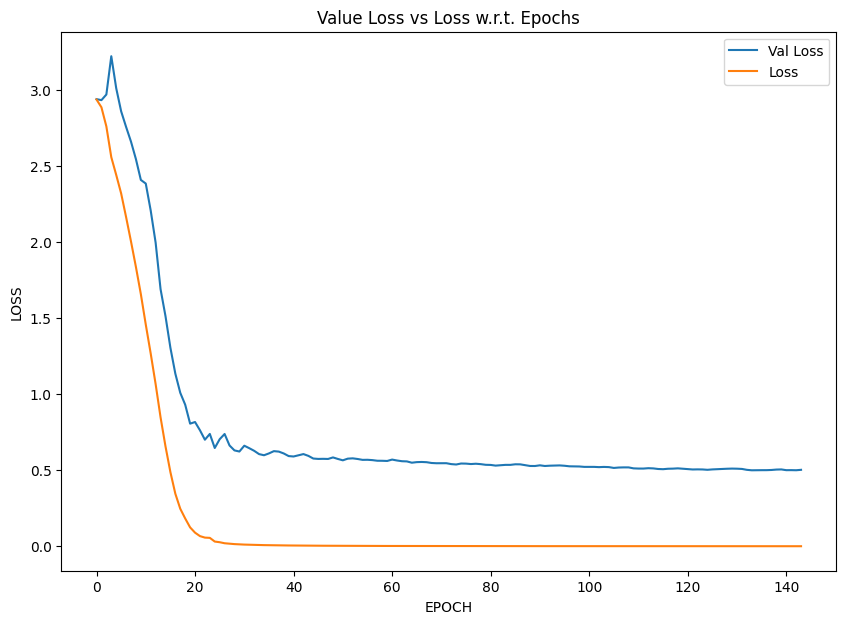

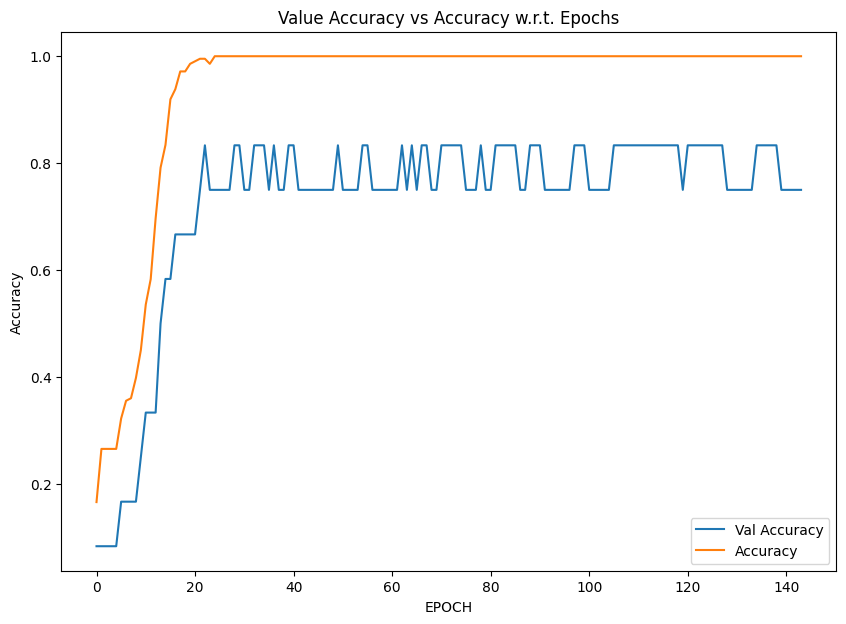

In [14]:
## Plotting the model 
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Value Loss vs Loss w.r.t. Epochs")
plt.plot(history.history['loss'], label="Loss")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.legend()
plt.show()
plt.figure(figsize=(10,7))
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Value Accuracy vs Accuracy w.r.t. Epochs")
plt.plot(history.history['accuracy'], label="Accuracy")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

## Testing the model on unseen Data
> TIP: When you deploy your model you should collect What user asked and what label was classified to keep training on new unseen data. This will help you improving your model in future.

>#### You gotta create the unseen data and then import its Embeddings here to test


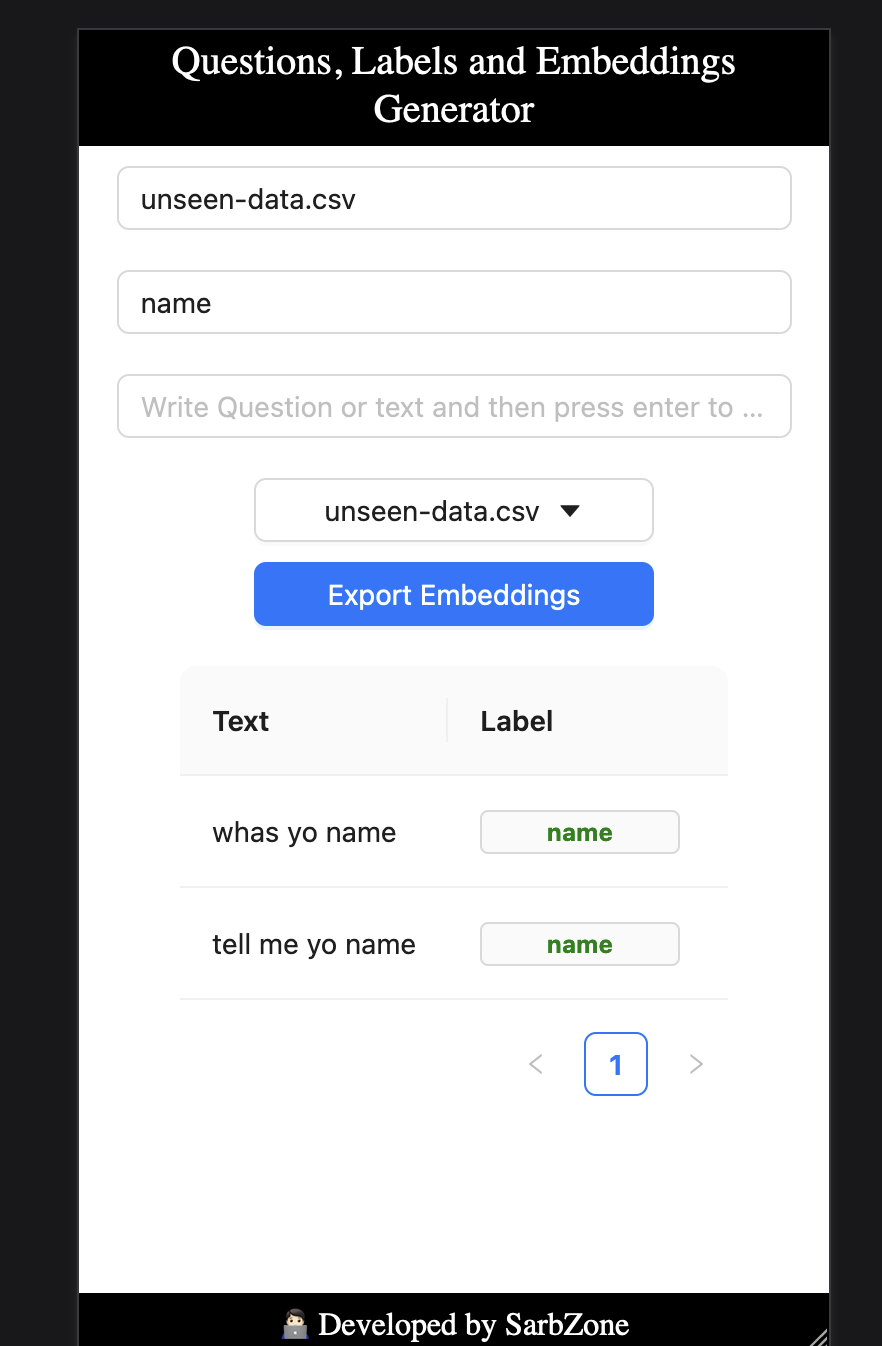

In [15]:
show_image_from_path('Demo_Images/Screenshot 2024-04-21 at 5.08.28 AM.png')

In [16]:
## Importing Unseen Data first 

test_emb = pd.read_json(EMB_DIRECTORY+"unseen-data.json")
test_emb.head()

,Text,Label,Embedding
0,tell me yo name,name,"[0.032687403261661, -0.015305050648748, 0.0555..."
1,whas yo name,name,"[-0.040336847305297005, 0.046720836311578, 0.0..."


In [17]:
test_data = tf.constant([test_emb['Embedding']], dtype=tf.float32)
test_data = tf.squeeze(test_data)

In [18]:

#Predicting
def predict_label(df:pd.DataFrame, embeddings, index):

    embedding = embeddings[index]
   
    prediction = model.predict(tf.expand_dims(embedding,axis=0))
    print(f"Text : {df['Text'][index]}")
    print(f"Label: {df['Label'][index]}")
    label = tf.argmax(prediction[0]).numpy()
    print(f"Predicted Class: {index_to_class_array[label]}")


In [20]:
predict_label(test_emb, test_data, 1)

1/1 [==============================] - 0s 17ms/step
Text : whas yo name
Label: name
Predicted Class: name


## Converting Model To JavaScript 🤖

In [21]:
tfjs.converters.save_keras_model(model=model, artifacts_dir='JavaScriptModel/model')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
